**Importing the Required Modules**

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer, RobustScaler

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.tree import ExtraTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import ShuffleSplit,  cross_val_score

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 4)
pd.set_option("plotting.backend", "matplotlib")

from google.colab import drive
drive.mount('/drive')

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


**Utility Functions**

In [51]:
def regression_metrics_report(y_pred, y, n_features, n_samples):
  errors = abs(y_pred - y)
  RMSE = float(format(np.sqrt(mean_squared_error(y_pred, y)), ".3f"))
  MSE = mean_squared_error(y, y_pred)
  MAE = mean_absolute_error(y, y_pred)
  R2 = r2_score(y, y_pred, multioutput="variance_weighted")
  adjR2 = 1 - ((1 - R2) * (n_samples - 1)) / (n_samples - n_features - 1)

  print(f"Average absolute error: {np.mean(errors):.3f}")
  print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
  print(f"Mean Squared Error (MSE): {MSE:.3f}")
  print(f"Mean Absolute Error (MAE): {MAE:.3f}")
  print(f"R2_Score: {R2:.3f}")
  print(f"Adjusted R2: {adjR2:.3f}")


**Freeze Random State**

In [52]:
np.random.seed(35)

**Installing the Required Modules**

In [53]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **1. Data Transformers**

In [54]:
TRAIN_PATH = "/drive/My Drive/rul/train_telemetry.csv"
TEST_PATH = "/drive/My Drive/rul/test_telemetry.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

## **1.1 Datatime Transformers**

In [55]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

## **1.2 Utility Transformer**

In [56]:
def identy_transformer():
  return FunctionTransformer(lambda x: x)

## **1.3 Full Dataset Transformer**

In [57]:
transform = make_column_transformer(
   (OrdinalEncoder(), ["age", "model"]),
   (sin_transformer(365), ["time_in_cycles"]),
   (cos_transformer(365), ["time_in_cycles"]),
   (RobustScaler(),
     ["voltmean_24h","rotatemean_24h","pressuremean_24h",
      "vibrationmean_24h", "voltsd_24h", "rotatesd_24h",
      "pressuresd_24h", "vibrationsd_24h", "voltmean_5d", "rotatemean_5d",
      "pressuremean_5d", "vibrationmean_5d", "voltsd_5d", "rotatesd_5d",
      "pressuresd_5d","vibrationsd_5d", "volts_entropy", "volts_benford",
      "volts_cidce", "volts_lzc", "press_max", "press_below", "press_above",
      "press_entropy", "press_benford", "press_cidce", "press_lzc",
      "vibra_max", "vibra_below", "vibra_above", "vibra_entropy",
      "vibra_benford", "vibra_cidce", "vibra_lzc", "rotate_max", "rotate_below",
      "rotate_above", "rotate_entropy", "rotate_benford", "rotate_cidce",
       "rotate_lzc","volts_max", "volts_below", "volts_above", "DI",
      ]),
   (identy_transformer(), ["error1", "error2","error3", "error4", "error5",
                           "comp1", "comp2", "comp3", "comp4"]))

# **2. Regressor Fitting**

## **2.1 Pipeline Creation**

In [72]:
 model = ExtraTreeRegressor()
 pipeline= make_pipeline(transform, model)

## **2.2 Model Fitting and Data Anonymization**

In [92]:
X_train = train_df
X_test  = test_df

Y_train = X_train["RUL_I"].values.astype(np.float).ravel()
Y_test = X_test["RUL_I"].values.astype(np.float).ravel()

#data anonymization
dropped_lst = ["machineID", 'datetime', 'RULWeek', 'failure', 'failed',
                'RUL', 'RUL_I']

X_train = X_train.drop(dropped_lst, axis=1)
X_test = X_test.drop(dropped_lst, axis=1)

pipeline.fit(X_train, Y_train);

Y_pred = pipeline.predict(X_test)

k = X_test.shape[1]
n = len(X_test)

regression_metrics_report(Y_pred, Y_test, k, n)

Average absolute error: 9.552
Root Mean Squared Error (RMSE): 20.100
Mean Squared Error (MSE): 403.992
Mean Absolute Error (MAE): 9.552
R2_Score: 0.650
Adjusted R2: 0.647


И так мы получили хорошее значение метрик $R^{2}$ и $adjR^{2}$ уже у дефолтного регрессора

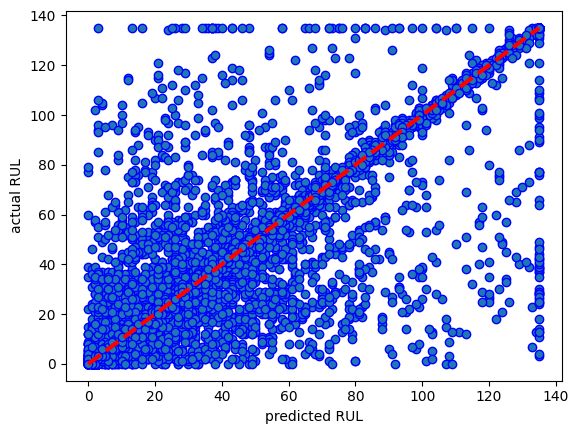

In [93]:
fig, ax = plt.subplots()
ax.scatter(Y_pred, Y_test, edgecolors=(0, 0, 1))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=3)
ax.set_xlabel('predicted RUL')
ax.set_ylabel('actual RUL')
plt.show()

И так у нас модель плохо предсказывает RUL как с максимальной величиной продолжительности безотказной работы так и для малых значений

## **2.3 Features Importance**

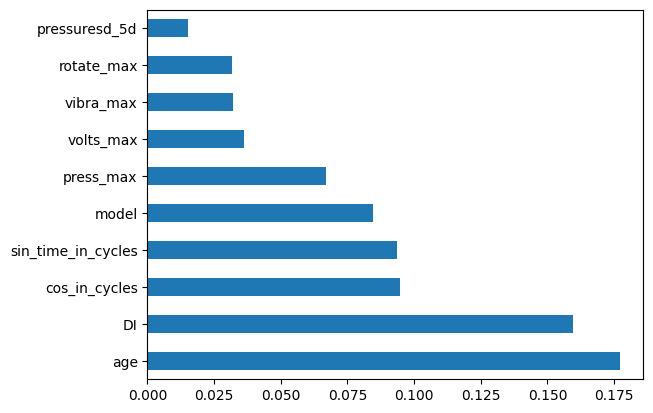

In [61]:
N_LARGEST = 10

TRANSFORM_COLUMN_NAMES = [
      "age", "model", "sin_time_in_cycles", "cos_in_cycles",
      "voltmean_24h","rotatemean_24h","pressuremean_24h",
      "vibrationmean_24h", "voltsd_24h", "rotatesd_24h",
      "pressuresd_24h", "vibrationsd_24h", "voltmean_5d", "rotatemean_5d",
      "pressuremean_5d", "vibrationmean_5d", "voltsd_5d", "rotatesd_5d",
      "pressuresd_5d","vibrationsd_5d", "volts_entropy", "volts_benford",
      "volts_cidce", "volts_lzc", "press_max", "press_below", "press_above",
      "press_entropy", "press_benford", "press_cidce", "press_lzc",
      "vibra_max", "vibra_below", "vibra_above", "vibra_entropy",
      "vibra_benford", "vibra_cidce", "vibra_lzc", "rotate_max", "rotate_below",
      "rotate_above", "rotate_entropy", "rotate_benford", "rotate_cidce",
      "rotate_lzc","volts_max", "volts_below", "volts_above", "DI",
      "error1", "error2","error3", "error4", "error5",
      "comp1", "comp2", "comp3", "comp4"]

feat_importances = pd.Series(model.feature_importances_, TRANSFORM_COLUMN_NAMES)
feat_importances.nlargest(N_LARGEST).plot(kind='barh')
plt.show()

Как видно для предсказания модели важны как качественные хорактеристики оборудования: возраст, модель так и количественные измерения физических величин
положения первого максимума в скользящем окне

# **3. Regressor Finetuning**

Попробуем найти оптимальные значения параметров максимизирующие $R^{2}$

## **3.1 Objective Function**

In [94]:
def objective(trial):
  param ={
      "criterion": trial.suggest_categorical("criterion",
                ["squared_error", "friedman_mse",
                                              "absolute_error", "poisson"]),
       "splitter": trial.suggest_categorical("splitter", ["random", "best"]),
       "max_features": trial.suggest_categorical("max_features",
                                             ["auto","log2","sqrt",None]),
       "max_depth": trial.suggest_int("max_depth", 1, 10),
       "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
       "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
       "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf",
                                                        0.1, .5)}
  model = ExtraTreeRegressor(**param)
  pipeline = make_pipeline(transform, model)
  cv = ShuffleSplit(n_splits=10,  random_state=42)

  score = cross_val_score(pipeline,  train_df, Y_train,  scoring="r2",  cv=cv)
  final_score = score.mean()
  return final_score

## **3.2 Finetuning**

так как мы имеем дело с разновидностью решающего дерева поставим выберем достаточно большое количество попыток максимизировать $R^2$

In [67]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

params = study.best_trial.params

print('Found params:')
print(params)

[I 2023-06-17 12:08:54,491] A new study created in memory with name: no-name-5892ef77-9b54-4b58-ad3a-ea16827acbe6
[I 2023-06-17 12:08:55,536] Trial 0 finished with value: 0.07573678409464729 and parameters: {'criterion': 'squared_error', 'splitter': 'random', 'max_features': None, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.22281962252656037}. Best is trial 0 with value: 0.07573678409464729.
[I 2023-06-17 12:08:56,438] Trial 1 finished with value: 0.01624689656645285 and parameters: {'criterion': 'squared_error', 'splitter': 'random', 'max_features': 'log2', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.2039673714916017}. Best is trial 0 with value: 0.07573678409464729.
[I 2023-06-17 12:09:58,196] Trial 2 finished with value: -0.00057495712656217 and parameters: {'criterion': 'absolute_error', 'splitter': 'best', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_s

Found params:
{'criterion': 'poisson', 'splitter': 'best', 'max_features': None, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.10071164292996289}


# **4. Regressor With Best Hyperparameters**

In [95]:
model = ExtraTreeRegressor(**params)
pipeline = make_pipeline(transform, model)

pipeline.fit(train_df, Y_train);

Y_pred = pipeline.predict(test_df).round()

k = test_df.shape[1]
n = len(test_df)

regression_metrics_report(Y_pred, Y_test, k, n)

Average absolute error: 23.632
Root Mean Squared Error (RMSE): 30.816
Mean Squared Error (MSE): 949.645
Mean Absolute Error (MAE): 23.632
R2_Score: 0.176
Adjusted R2: 0.170


Как видно максимизация только ухудшила исходный результат. Причина такого результата довольна проста высокая дисперсия оценок получаемых с помощью решающих деревьев

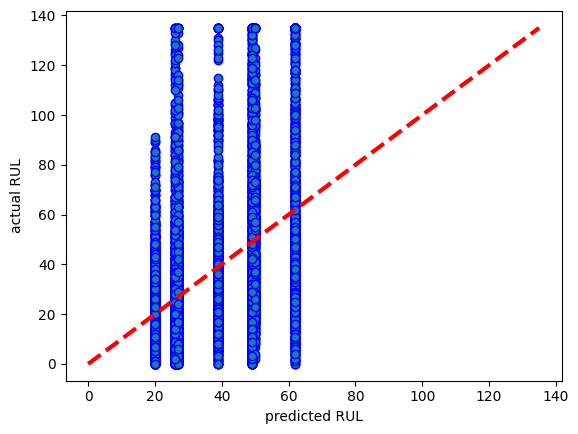

In [96]:
fig, ax = plt.subplots()
ax.scatter(Y_pred, Y_test, edgecolors=(0, 0, 1))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=3)
ax.set_xlabel('predicted RUL')
ax.set_ylabel('actual RUL')
plt.show()

Как видно максимизация только ухудшила исходный результат. Причина такого результата довольна проста высокая дисперсия оценок получаемых с помощью решающих деревьев

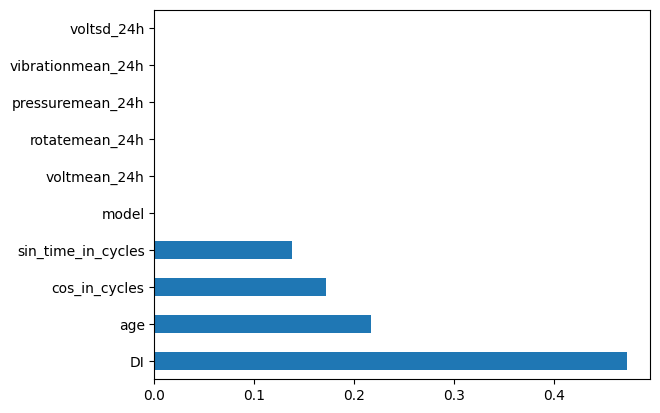

In [70]:
feat_importances = pd.Series(model.feature_importances_, TRANSFORM_COLUMN_NAMES)
feat_importances.nlargest(N_LARGEST).plot(kind='barh')
plt.show()

Очевидно изменились и веса признаков используемых для предсказаний